#  dependencies

In [1]:
import os
from pathlib import Path
import json
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import librosa, librosa.display
import pywt
from pydub import AudioSegment
import shutil
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
import wave
import soundfile as sf
import seaborn as sns

# data loading

In [2]:
train_file= os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/record')
label_file=os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/labels')
event_level=[]
file_name=[]
files=os.listdir(label_file)
records=pd.DataFrame(columns=['Path','record_annotation'])
events=pd.DataFrame(columns=['Path','start','end','type','time'])
for i in files:
    labels=json.load(open(os.path.join(label_file,i)))
    file_name={'Path':Path(i).stem+'.wav'}
    labels.update(file_name) 
    records.loc[len(records.index)]=labels
    event_level=labels['event_annotation']
    if len(event_level)==0:
        file_name.update({'type':'Poor Quality','time':0})
        events.loc[len(events.index)]=file_name
    for x in range(len(event_level)):
        t1=int(event_level[x]['start'])
        t2=int(event_level[x]['end'])
        file_name.update({'time':t2-t1})
        event_level[x].update(file_name)
        events.loc[len(events.index)]=event_level[x]

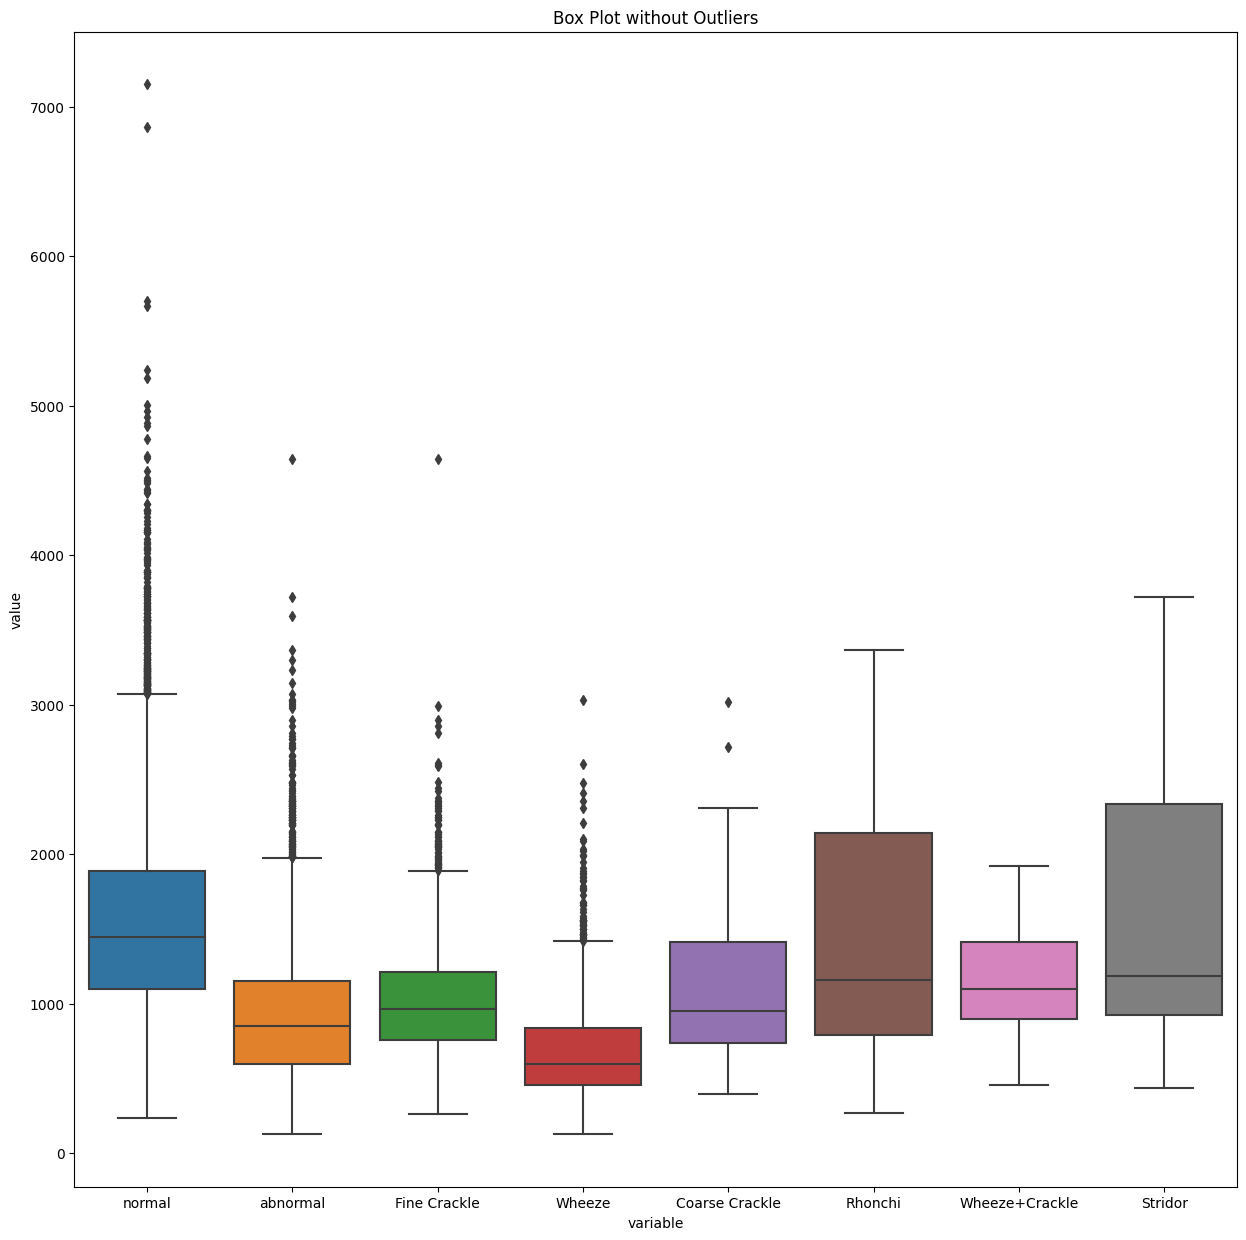

In [6]:
type_0_rows = events[events["type"] == 'Normal']
# Assuming 'events' is your DataFrame
desired_types = ["Fine Crackle", "Wheeze", "Coarse Crackle", "Rhonchi", "Wheeze+Crackle", "Stridor"]

type_1_rows = events[events["type"].isin(desired_types)]
type_1_1=events[events["type"] == "Fine Crackle"]
type_1_2=events[events["type"] == "Wheeze"]
type_1_3=events[events["type"] == "Coarse Crackle"]
type_1_4=events[events["type"] == "Rhonchi"]
type_1_5=events[events["type"] == "Wheeze+Crackle"]
type_1_6=events[events["type"] == "Stridor"]

# Now 'type_1_rows' contains rows where the 'type' column matches any of the desired types

# Filter rows where "type" is 1
m={
    'normal':type_0_rows['time'],
    'abnormal':type_1_rows['time'],
    "Fine Crackle":type_1_1['time'],
    "Wheeze":type_1_2['time'],
    "Coarse Crackle":type_1_3['time'],
    "Rhonchi":type_1_4['time'],
    "Wheeze+Crackle":type_1_5['time'],
    "Stridor":type_1_6['time']
    
}
df = pd.DataFrame(m)
df_melted = pd.melt(df)
plt.figure(figsize=(15,15))
sns.boxplot(x='variable', y='value', data=df_melted, showfliers=True)
plt.title("Box Plot without Outliers")
plt.show()

In [5]:
events["type"].value_counts()

type
Normal            9345
Fine Crackle      1476
Wheeze            1059
Poor Quality       230
Rhonchi            148
Coarse Crackle     100
Stridor             49
Wheeze+Crackle      36
Name: count, dtype: int64

In [3]:
pd.set_option('future.no_silent_downcasting', True)
event_encode={"Normal":0,"Fine Crackle":1,"Wheeze":1,"Coarse Crackle":1,"Rhonchi":1,"Wheeze+Crackle":1,"Stridor":1,"Poor Quality":2}
encoded_event=events.replace({"type":event_encode})
record_encode={"Normal":0,"DAS":1,"CAS":1,"CAS & DAS":1,"Poor Quality":2}
encoded_record=records.replace({"record_annotation":record_encode})

In [4]:
events=encoded_event.copy()


***droping poor quality***

In [5]:
events.drop(events[events['type']==2].index,inplace=True)
events.reset_index(drop=True, inplace=True)

In [7]:
#removing all records longer than 3.7s 
events.drop(events[events['time']>3721].index,inplace=True)
events.reset_index(drop=True, inplace=True)

In [25]:
events["type"].value_counts()

type
0    9260
1    2867
Name: count, dtype: int64

In [8]:
#type 0 -type 1=6393
# Define the number of rows to drop
n = 6393 # Replace with your desired number


# Drop n random rows
events = events.drop(events[events['type']==0].sample(n).index)
events.reset_index(drop=True, inplace=True)

type
1    50.0
0    50.0
Name: proportion, dtype: float64

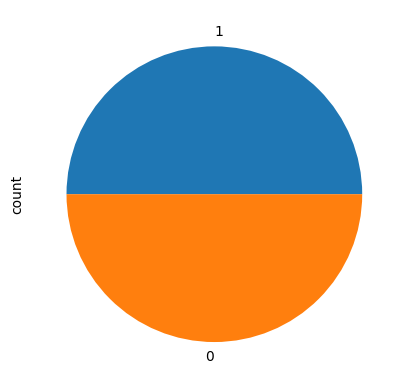

In [28]:
events['type'].value_counts().plot(kind="pie")
events['type'].value_counts(normalize=True)*100


# removed the extra data and some of the outliers

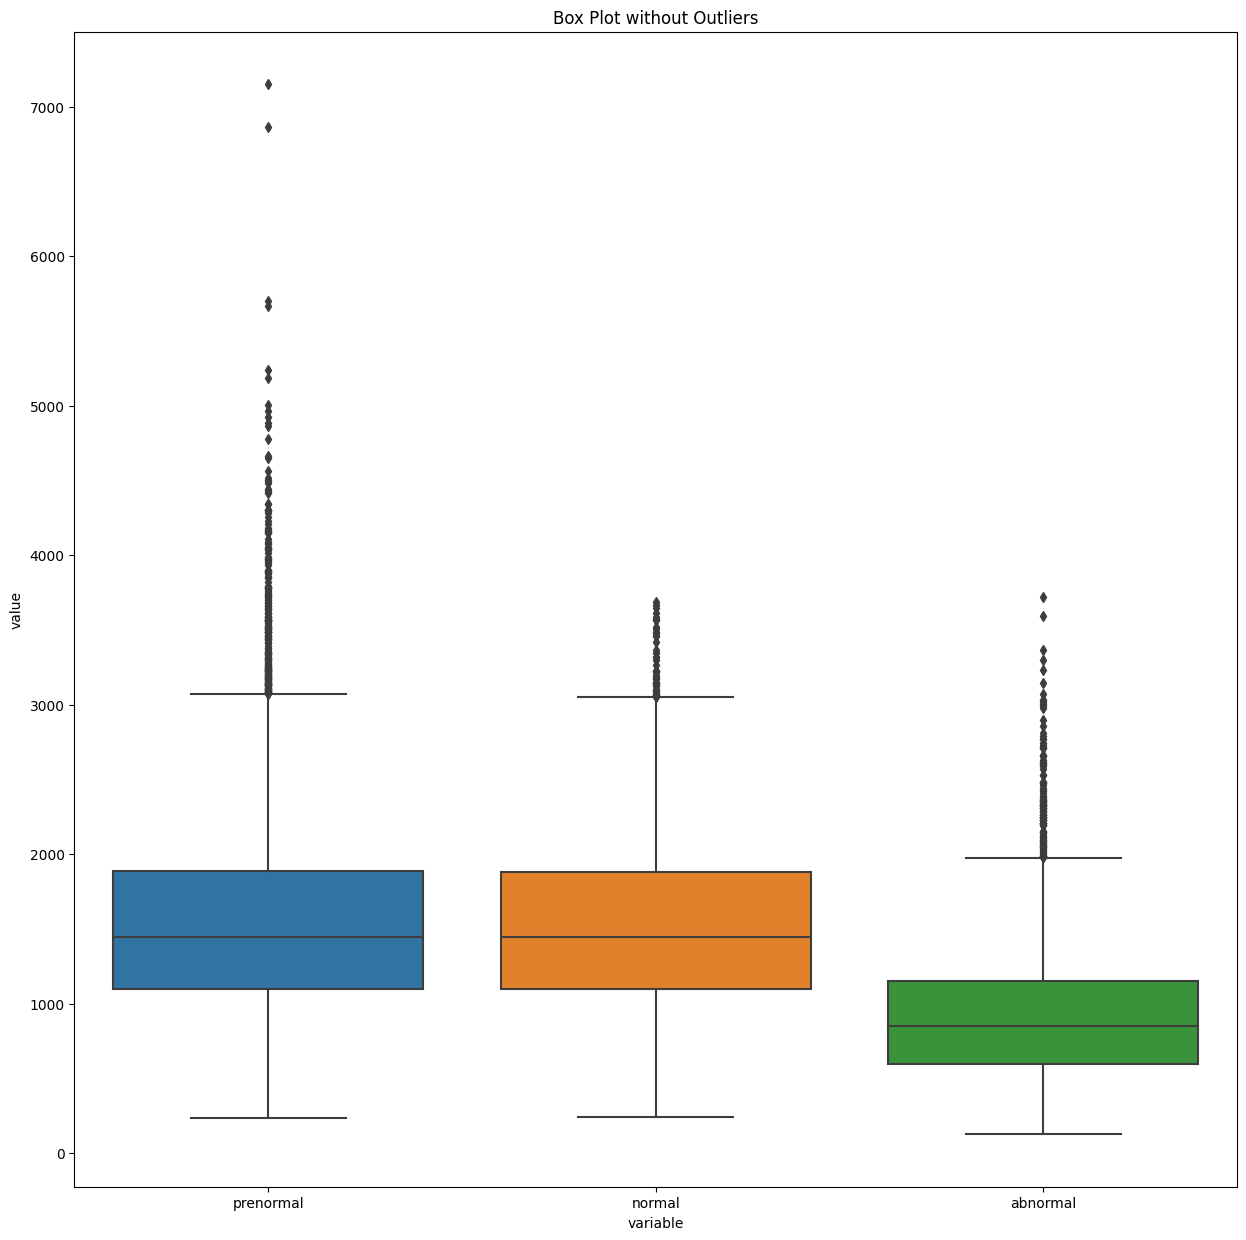

In [29]:
type_0_rows = events[events["type"] == 0]
type_1_rows = events[events["type"]==1]
type_0_1_rows = encoded_event[encoded_event["type"] == 0]
# Assuming 'events' is your DataFrame
# desired_types = ["Fine Crackle", "Wheeze", "Coarse Crackle", "Rhonchi", "Wheeze+Crackle", "Stridor"]
# type_1_rows = events[events["type"].isin(desired_types)]
# type_1_1=events[events["type"] == "Fine Crackle"]
# type_1_2=events[events["type"] == "Wheeze"]
# type_1_3=events[events["type"] == "Coarse Crackle"]
# type_1_4=events[events["type"] == "Rhonchi"]
# type_1_5=events[events["type"] == "Wheeze+Crackle"]
# type_1_6=events[events["type"] == "Stridor"]

# Now 'type_1_rows' contains rows where the 'type' column matches any of the desired types

# Filter rows where "type" is 1
m={
    'prenormal':type_0_1_rows['time'],
    'normal':type_0_rows['time'],
    'abnormal':type_1_rows['time']
#     "Fine Crackle":type_1_1['time'],
#     "Wheeze":type_1_2['time'],
#     "Coarse Crackle":type_1_3['time'],
#     "Rhonchi":type_1_4['time'],
#     "Wheeze+Crackle":type_1_5['time'],
#     "Stridor":type_1_6['time']
    
}
df = pd.DataFrame(m)
df_melted = pd.melt(df)
plt.figure(figsize=(15,15))
sns.boxplot(x='variable', y='value', data=df_melted, showfliers=True)
plt.title("Box Plot without Outliers")
plt.show()

In [21]:
events.to_csv("balanced.csv")

pre_events=events.copy()

In [10]:
train_file= os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/record')
label_file=os.path.join('/kaggle/input/sprsound-nosplit/SPRSound-main/labels')
# records=pd.read_csv(os.path.join('/kaggle/input/output/records.csv'),index_col=[0])
# events=pd.read_csv(os.path.join('/kaggle/input/output/events.csv'),index_col=[0])
# events=pd.read_csv(os.path.join('/kaggle/working/balanced.csv'),index_col=[0])

***making nesscary directories***

In [11]:

if not os.path.exists("events"):
    os.makedirs("events")

***band pass filter***

In [12]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Define your lowcut and highcut frequencies
lowcut = 60.0
highcut = 1300.0

***splitting records to events and applying the band pass filter***

In [13]:
events.drop(events[events['type']==2].index,inplace=True)
events.reset_index(drop=True, inplace=True)
name='name'
events.loc[:, "event_path"] = None


s=0
for i in range(len(events)):
    if name == events['Path'][i]:
        s+=1
    else:
        s=0
        name=events['Path'][i]
    path,t1,t2,_,_,_,= events.loc[i]
    newAudio = AudioSegment.from_wav(os.path.join(train_file,path))
    newAudio = newAudio[int(t1):int(t2)]
    newAudio.export(os.path.join("events",Path(path).stem+"_S"+str(s)+".wav"), format="wav") 
    events.loc[i, "event_path"] = os.path.join('events',Path(path).stem+"_S"+str(s)+".wav")
    # Load the trimmed audio file
    audio, sr = librosa.load(events.loc[i, "event_path"])
    # Apply the filter to the audio
    audio_filtered = butter_bandpass_filter(audio, lowcut, highcut, sr, order=6)
    # Save the filtered audio using soundfile.write instead of librosa.output.write_wav
    sf.write(os.path.join("events",Path(path).stem+"_S"+str(s)+".wav"), audio_filtered, sr)


In [14]:
events.to_csv("events_processed.csv")

this zip file will contain the new dataset for the model

In [15]:
import os
import zipfile

zip_file_path = 'events.zip'
directory = "events"
folder = os.listdir(directory)

with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
    for file in folder:
        zip_file.write(os.path.join(directory, file),arcname=file)  # Include the directory path
